<a href="https://colab.research.google.com/github/DrewRust/DS-Unit-2-Build_Week/blob/master/Exoplanets_Finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA EXOPLANETS

### Data Modeling

#### Exoplanets are planets outside our solar system.  Above is an artist's rendering of NASA's Kepler Space Telescope searching for such exoplanets.

As of the time of writing this there are 4,164 "confirmed" exoplanets.  However, there are thousands more other "candidate" exoplanets that require more observation to have their status changed to confirmed.  

The discovery method most often successful is the transit method as the exoplanet passes in between it's star and the telescope.  The dimming of the light from that star can then be measured and the orbit studied. 

The dataset that I chose to look at is the Planetary Systems Alpha release (link) which is essentially all the planetary datasets combined.  The data is 26,336 rows and 118 columns.  I looked at all the columns and some were either mostly nulls, duplicates or the same information just with a different metric, or irrelevant to what I chose to predict.  

What I chose to predict with my data model was looking at my chosen data columns could I predict whether a planet was confirmed or just a candidate.

### Load csv and pip installs

In [ ]:
import sys
if 'google.colab' in sys.modules:
    DATA_PATH = "https://raw.githubusercontent.com/DrewRust/Kepler_Planet_data/master/AllPlanets.csv"
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install -q dtreeviz

else:
    DATA_PATH = '../data/'

### Most of necessary imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas.util.testing as tm
import eli5
from eli5.sklearn import PermutationImportance

#### Read in data from github

In [ ]:
allPlanets_df = pd.read_csv(DATA_PATH) 

## List columns needed

In [ ]:
columnlist= ['pl_name', # planet name
                           'hostname', # star name
                           'soltype', # confirmed or candidate
                           'default_flag', # only confirmed planets can have a 1 (multiple rows for some planets)
                           'discoverymethod', # transit is the most common categorical (11)
                           'disc_locale', # location of observation of planet discovery (ground or space (23,000 maj))
                           'st_teff', # stellar temperature
                           'st_rad', # stellar radius
                           'st_mass', # stellar mass
                           'st_met', # metallicity compared to hydrogen content
                           'st_metratio', # categorical metal content
                           'st_logg', # gravitational acceleration experienced at star surface
                           'pl_letter', # b is the most common for b being next to a the star
                           'pl_orbper', # Time the planet takes to make a complete orbit around the host star or system
                           'pl_rade', # planet radius in earth radii
                           'pl_radj', # planet radius in jupiter radii
                           'pl_eqt', # planet equilibrium temperature
                           'pl_insol', # temperature measured in units from the Earth from the Sun.
                           'pl_tranmid', # time of Transit Midpoint in days
                           'pl_imppar', # sky projected distance between the center of the stellar disc and planet disc
                           'pl_trandep', # flux caused by transit of planet eclipsing star
                           'pl_trandurd', # transit duration in hours
                           'pl_ratdor', # ratio of the distance between the planet and the star at mid-transit divided by the star radius
                           'pl_ratror', # ratio of planet to stellar radius
                           'sy_snum', # number of stars in the planetary system
                           'sy_pnum', # number of planets in the planetary system
                           'sy_pm', # total proper motion change
                           'sy_dist', # distance to the planetary system in units of parsecs
                           'sy_plx', # difference in the angular position two opposite positions within the Earth's orbit
                           'sy_vmag', # brightness of the host star as measured using the Kepler bandpass
                           'ra', # east and west
                           'dec'] # north and south

### Run data organize function

In [ ]:
def wrangle(dataframe):
    
    # Prevent SettingWithCopyWarning
    dataframe = dataframe.copy()

    dataframe = dataframe[columnlist]

    dataframe['IS_Confirmed_Planet'] = dataframe.soltype.apply(lambda x: True if x == "CONFIRMED" else False)
    dataframe = dataframe.drop(columns='soltype')

    return dataframe 

In [ ]:
allPlanets = wrangle(allPlanets_df)

### Train, Val, and Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(allPlanets, random_state=42, shuffle="True")

In [ ]:
train, test = train_test_split(train, random_state=42)

In [ ]:
train.shape, val.shape, test.shape

((14814, 32), (6584, 32), (4938, 32))

## Get baseline score by just guessing

In [ ]:
target = 'IS_Confirmed_Planet'
y_train = train[target]
true_false_ct = y_train.value_counts(normalize=True)

In [ ]:
true_false_ct

True     0.537465
False    0.462535
Name: IS_Confirmed_Planet, dtype: float64

In [ ]:
majority_class = y_train.mode()[0]
majority_class

True

In [ ]:
y_train_pred = [majority_class]*len(y_train)

### 0.537465 matches the above true.  So if you guess the most popular outcome you would be correct that it is a planet that percentage of the time.

In [ ]:
from sklearn.metrics import accuracy_score
baseline = accuracy_score(y_train, y_train_pred)
false_percentage = 1 - baseline
print(true_false_ct)
print("Baseline True percentage - ", baseline)
print(false_percentage)

True     0.537465
False    0.462535
Name: IS_Confirmed_Planet, dtype: float64
Baseline True percentage -  0.5374645605508303
0.46253543944916975


#### Train model from here using these columns (columns I graphed in the visuals)

In [ ]:
mynumfeatures = ['pl_eqt', 'pl_orbper', 'pl_ratdor', 'pl_trandep', 'pl_radj', 'pl_ratror', 'pl_imppar', 'st_mass', 'pl_trandurd', 'pl_rade', 'ra', 'dec']
print(len(mynumfeatures))

12


In [ ]:
# st_metratio (5 features) discoverymethod (9 features) disc_locale (4 features)
mycatfeatures = ['st_metratio', 'discoverymethod', 'disc_locale']

### Once the categorical features are one hot encoded it'll add up to 30 total features

In [ ]:
target = 'IS_Confirmed_Planet'
features = mynumfeatures + mycatfeatures

In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

### Logistic Regression using one hot encoder

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
numfirst6 = mynumfeatures[0:5]
numlast6 = mynumfeatures[5:12]
print(*numfirst6, sep = ", ")
print(*numlast6, sep = ", ")

pl_eqt, pl_orbper, pl_ratdor, pl_trandep, pl_radj
pl_ratror, pl_imppar, st_mass, pl_trandurd, pl_rade, ra, dec


In [ ]:
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

print("Exoplanet is Confirmed?")
print("True: %0.6f" % baseline)
print("False: %0.6f" % false_percentage)

print("\nBaseline Score: %0.6f" % baseline)

print("\nCategorical features: ")
print(*mycatfeatures, sep = ", ")

print("\nNumeric features: ")
print(*numfirst6, sep = ", ")
print(*numlast6, sep = ", ")

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
Valscore1 = model.score(X_val_scaled, y_val)

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

accuracy1 = accuracy_score(y_test, y_pred)
print("\nLogistic Regression Score: ")
print("Validation Accuracy: %0.6f" % Valscore1)
print("Test Accuracy: %0.6f" % accuracy1)

Exoplanet is Confirmed?
True: 0.537465
False: 0.462535

Baseline Score: 0.537465

Categorical features: 
st_metratio, discoverymethod, disc_locale

Numeric features: 
pl_eqt, pl_orbper, pl_ratdor, pl_trandep, pl_radj
pl_ratror, pl_imppar, st_mass, pl_trandurd, pl_rade, ra, dec

Logistic Regression Score: 
Validation Accuracy: 0.906136
Test Accuracy: 0.901782


### Confirming test accuracy score below by finding the average of how many times my model was right.

In [ ]:
test.head(2)

,pl_name,hostname,default_flag,discoverymethod,disc_locale,st_teff,st_rad,st_mass,st_met,st_metratio,st_logg,pl_letter,pl_orbper,pl_rade,pl_radj,pl_eqt,pl_insol,pl_tranmid,pl_imppar,pl_trandep,pl_trandurd,pl_ratdor,pl_ratror,sy_snum,sy_pnum,sy_pm,sy_dist,sy_plx,sy_vmag,ra,dec,IS_Confirmed_Planet
13892,Kepler-246 c,Kepler-246,0,Transit,Space,5434.0,0.87,0.90,0.01,[Fe/H],4.52,c,11.187140,1.70,0.152,NaN,NaN,2.454970e+06,NaN,NaN,0.13362,NaN,0.01757,1,2,9.854808,626.078,1.56877,15.197,296.483401,42.663381,True
20370,Kepler-581 b,Kepler-581,0,Transit,Space,5601.0,0.83,0.91,-0.12,[Fe/H],4.56,b,40.606982,2.16,NaN,475.0,12.05,2.455032e+06,0.0279,0.06964,5.71900,55.52,0.02388,1,1,24.958347,703.758,1.39278,14.701,295.432655,40.648187,False


In [ ]:
submission = test[['pl_name']].copy()
submission

,pl_name
13892,Kepler-246 c
20370,Kepler-581 b
22399,Kepler-761 b
2022,HD 6434 b
7091,Kepler-1239 b
...,...
4342,Kepler-1005 b
17015,Kepler-355 c
20749,Kepler-611 b
4750,Kepler-104 c


In [ ]:
submission["LR_Prediction"] = y_pred

In [ ]:
actual_confirmed = test['IS_Confirmed_Planet']

In [ ]:
submission = submission.join(actual_confirmed)

In [ ]:
submission.head()

,pl_name,LR_Prediction,IS_Confirmed_Planet
13892,Kepler-246 c,True,True
20370,Kepler-581 b,False,False
22399,Kepler-761 b,False,False
2022,HD 6434 b,True,True
7091,Kepler-1239 b,False,False


In [ ]:
submission = submission.reset_index(drop=True)

In [ ]:
submission.head()

,pl_name,LR_Prediction,IS_Confirmed_Planet
0,Kepler-246 c,True,True
1,Kepler-581 b,False,False
2,Kepler-761 b,False,False
3,HD 6434 b,True,True
4,Kepler-1239 b,False,False


In [ ]:
x = 0
for ind in submission.index:
  if (submission["LR_Prediction"][ind] == submission["IS_Confirmed_Planet"][ind]):
    x += 1
  else:
    continue

### Below is just confirming how many times my model was right.  It was right 4,453 times out 4,938.  The above test score should match below as well: Test accuracy: 0.9017820980153909 and it does.

In [ ]:
print("Correct predictions: ", x)
# print("Incorrect: ", (len(submission) - x))
print("Total predictions: ", len(submission))
computed_avg = (x / (len(submission)))
print("\nAverage times the model was right: %0.6f" % computed_avg)
print("Logistic Regression Test Accuracy: %0.6f" % accuracy1)
if (computed_avg == accuracy1):
  print("Score matches computed Avg.")
else:
  print("doesn't match")
print("\n")
print("First 5 LR Model predictions out of " + str(len(submission)) + " total.")  
print("\n")
submission.head(5)

Correct predictions:  4453
Total predictions:  4938

Average times the model was right: 0.901782
Logistic Regression Test Accuracy: 0.901782
Score matches computed Avg.


First 5 LR Model predictions out of 4938 total.




,pl_name,LR_Prediction,IS_Confirmed_Planet
0,Kepler-246 c,True,True
1,Kepler-581 b,False,False
2,Kepler-761 b,False,False
3,HD 6434 b,True,True
4,Kepler-1239 b,False,False


### Get Permutated feature importances

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    random_state=42
)
permuter.fit(X_val_scaled, y_val)

PermutationImportance(cv='prefit',
                      estimator=LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=-1, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                      n_iter=5, random_state=42, refit=True,
                      scoring='accuracy')

In [ ]:
feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

disc_locale_Multiple Locale                      0.000000
discoverymethod_Pulsation Timing Variations      0.000000
discoverymethod_Pulsar Timing                    0.000000
disc_locale_Multiple Locales                     0.000152
discoverymethod_Eclipse Timing Variations        0.000152
discoverymethod_Orbital Brightness Modulation    0.000182
pl_rade                                          0.000273
dec                                              0.000304
ra                                               0.000486
pl_trandep                                       0.000668
st_metratio_[Me/H]                               0.000729
st_metratio_[m/H]                                0.000729
discoverymethod_Imaging                          0.000820
discoverymethod_Transit Timing Variations        0.000942
pl_ratdor                                        0.001124
pl_ratror                                        0.001549
pl_imppar                                        0.001610
discoverymetho

In [ ]:
permutations = pd.Series(permuter.feature_importances_, feature_names)

### Graphing all features (12 numeric and 3 categoricals that become 18 after being encoded) 30 total features

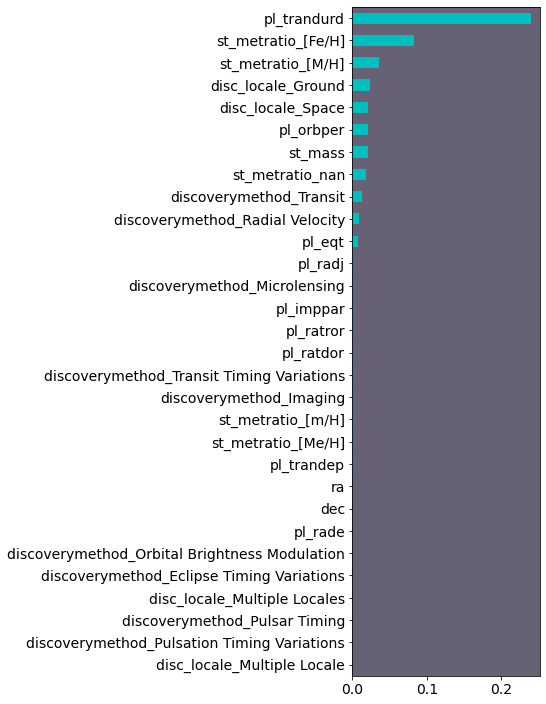

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 10))
plt.rcParams['axes.facecolor'] = '#666175'
plt.rcParams.update({'font.size': 14})
plt.rc('ytick',labelsize=14, color = 'black')
permutations.sort_values().plot.barh(color='c')
plt.tight_layout()
# plt.savefig('importantfeatures.png', dpi = 300)
plt.show();

In [ ]:
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2393 ± 0.0094,pl_trandurd
0.0831 ± 0.0067,st_metratio_[Fe/H]
0.0363 ± 0.0028,st_metratio_[M/H]
0.0235 ± 0.0017,disc_locale_Ground
0.0220 ± 0.0034,disc_locale_Space
0.0212 ± 0.0027,pl_orbper
0.0210 ± 0.0043,st_mass
0.0181 ± 0.0024,st_metratio_nan
0.0128 ± 0.0029,discoverymethod_Transit
0.0090 ± 0.0017,discoverymethod_Radial Velocity


### Below select the most important features of the model (11 top features)

In [ ]:
print(f'Shape before removing features: {X_train_encoded.shape}')

Shape before removing features: (14814, 30)


In [ ]:
minimum_importance = 0.005
mask = permuter.feature_importances_ > minimum_importance
mask

array([ True,  True, False, False, False, False, False,  True,  True,
       False, False, False,  True,  True,  True, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True, False, False])

In [ ]:
top_features = X_train_encoded.columns[mask]
X_train_top_features = X_train_encoded[top_features]

In [ ]:
print(f'Shape after removing features: {X_train_top_features.shape}')

Shape after removing features: (14814, 11)


In [ ]:
X_train_top_features.columns

Index(['pl_eqt', 'pl_orbper', 'st_mass', 'pl_trandurd', 'st_metratio_[Fe/H]',
       'st_metratio_nan', 'st_metratio_[M/H]', 'discoverymethod_Transit',
       'discoverymethod_Radial Velocity', 'disc_locale_Space',
       'disc_locale_Ground'],
      dtype='object')

In [ ]:
top_features

Index(['pl_eqt', 'pl_orbper', 'st_mass', 'pl_trandurd', 'st_metratio_[Fe/H]',
       'st_metratio_nan', 'st_metratio_[M/H]', 'discoverymethod_Transit',
       'discoverymethod_Radial Velocity', 'disc_locale_Space',
       'disc_locale_Ground'],
      dtype='object')

In [ ]:
# mynumfeatures and mycatfeatures are from above
target = 'IS_Confirmed_Planet'
features = mynumfeatures + mycatfeatures

In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

### Run the model again without features with a minimum_importance <= 0.005 (19 features)

LR with 11 most important features: 
Validation Accuracy 0.904465
Test Accuracy 0.899352
Model still maintained most accuracy: 

Validation loss of only: 0.001671
Test accuracy loss of only : 0.002430




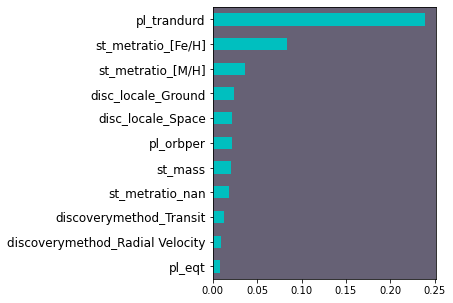

In [ ]:
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_select_col = X_train_encoded[top_features]
X_train_imputed = imputer.fit_transform(X_train_select_col)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)
print("LR with 11 most important features: ")

X_val_encoded = encoder.transform(X_val)
X_val_select_col = X_val_encoded[top_features]
X_val_imputed = imputer.transform(X_val_select_col)
X_val_scaled = scaler.transform(X_val_imputed)
Valscore2 = model.score(X_val_scaled, y_val)
print("Validation Accuracy %0.6f" % Valscore2)

X_test_encoded = encoder.transform(X_test)
X_test_select_col = X_test_encoded[top_features]
X_test_imputed = imputer.transform(X_test_select_col)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)
accuracy2 = accuracy_score(y_test, y_pred)
print("Test Accuracy %0.6f" % accuracy2)

print("Model still maintained most accuracy: ")
print("\nValidation loss of only: %0.6f" % (Valscore1 - Valscore2))
print("Test accuracy loss of only : %0.6f" % (accuracy1 - accuracy2))
print("\n")
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(4, 5))
plt.rcParams['axes.facecolor'] = '#666175'
plt.rc('ytick',labelsize=12, color = 'black')
top_11 = permutations.nlargest(11)
top_11.sort_values().plot.barh(color='c')
plt.show();

### The model only lost 2/1000 percent accuracy for the test score

### Graphing top 11 features used in model above

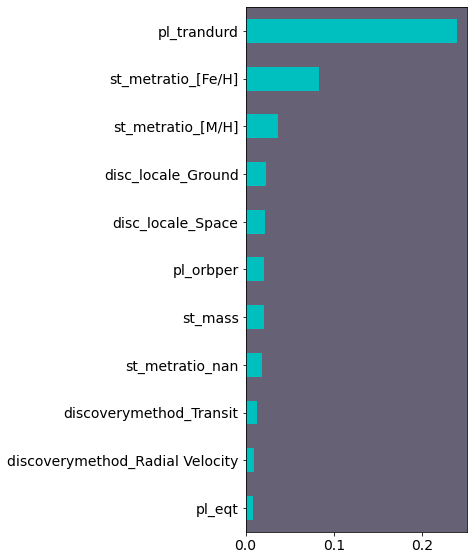

In [ ]:
plt.figure(figsize=(7, 8))
plt.rcParams['axes.facecolor'] = '#666175'
plt.rcParams.update({'font.size': 14})
plt.rc('ytick',labelsize=14, color = 'black')
top_11 = permutations.nlargest(11)
top_11.sort_values().plot.barh(color='c')
plt.tight_layout()
# plt.savefig('importantfeatures.png', dpi = 300)
plt.show();

### Decision Tree classifier fits much better than logistic regression - too good even

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')
# print(f'Prints the same as below: {pipeline.score(X_test, y_test)}')
y_pred = pipeline.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train accuracy: 1.0
Validation accuracy: 0.9957472660996355
Test Accuracy: 0.9955447549615228


### Fit Decision Tree with only the 12 numeric variables

In [ ]:
print(mynumfeatures)
len(mynumfeatures)

['pl_eqt', 'pl_orbper', 'pl_ratdor', 'pl_trandep', 'pl_radj', 'pl_ratror', 'pl_imppar', 'st_mass', 'pl_trandurd', 'pl_rade', 'ra', 'dec']


12

In [ ]:
target = 'IS_Confirmed_Planet'
features = mynumfeatures

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train accuracy: 1.0
Validation accuracy: 0.9924058323207776
Test Accuracy: 0.9933171324422844


### Fit decision tree with only the categoricals (st_metratio, discoverymethod, disc_locale)

In [ ]:
features = mycatfeatures

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train accuracy: 0.7687997839881193
Validation accuracy: 0.7636695018226003
Test Accuracy: 0.7575941676792224


### Pick some column variables and see how good I can get the model score.  First Decision tree then random forest classifier.

### columns = 'pl_orbper', 'st_mass', 'pl_rade', 'discoverymethod'

### Decision Tree first

In [ ]:
print(mynumfeatures)
print(mycatfeatures)

['pl_eqt', 'pl_orbper', 'pl_ratdor', 'pl_trandep', 'pl_radj', 'pl_ratror', 'pl_imppar', 'st_mass', 'pl_trandurd', 'pl_rade', 'ra', 'dec']
['st_metratio', 'discoverymethod', 'disc_locale']


In [ ]:
newnumfeat = ['pl_orbper', 'st_mass', 'pl_rade']
newcatfeat = ['discoverymethod']

In [ ]:
features = newnumfeat + newcatfeat
print(features)

['pl_orbper', 'st_mass', 'pl_rade', 'discoverymethod']


In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)

dttrain = pipeline.score(X_train, y_train)
dtval = pipeline.score(X_val, y_val)
y_pred = pipeline.predict(X_test)
dttest = metrics.accuracy_score(y_test, y_pred)

print("Decision Tree Classifier: ")
print("\nFeatures: ")
print(*features, sep = ", ")

print("\nTrain accuracy:  %0.6f" % dttrain)
print("Validation accuracy: %0.6f" % dtval)
print("Test Accuracy: %0.6f" % dttest)

Decision Tree Classifier: 

Features: 
pl_orbper, st_mass, pl_rade, discoverymethod

Train accuracy:  0.999325
Validation accuracy: 0.794806
Test Accuracy: 0.791211


In [ ]:
print("Decision Tree Classifier: ")
print("\nFeatures: ")
print(*features, sep = ", ")

print("\nTrain accuracy:  %0.6f" % dttrain)
print("Validation accuracy: %0.6f" % dtval)
print("Test Accuracy: %0.6f" % dttest)

Decision Tree Classifier: 

Features: 
pl_orbper, st_mass, pl_rade, discoverymethod

Train accuracy:  0.999325
Validation accuracy: 0.794806
Test Accuracy: 0.791211


In [ ]:
import graphviz
from sklearn.tree import export_graphviz
import collections
import pydotplus
from IPython.display import Image, display_svg, SVG

### Custom colors and horizontal

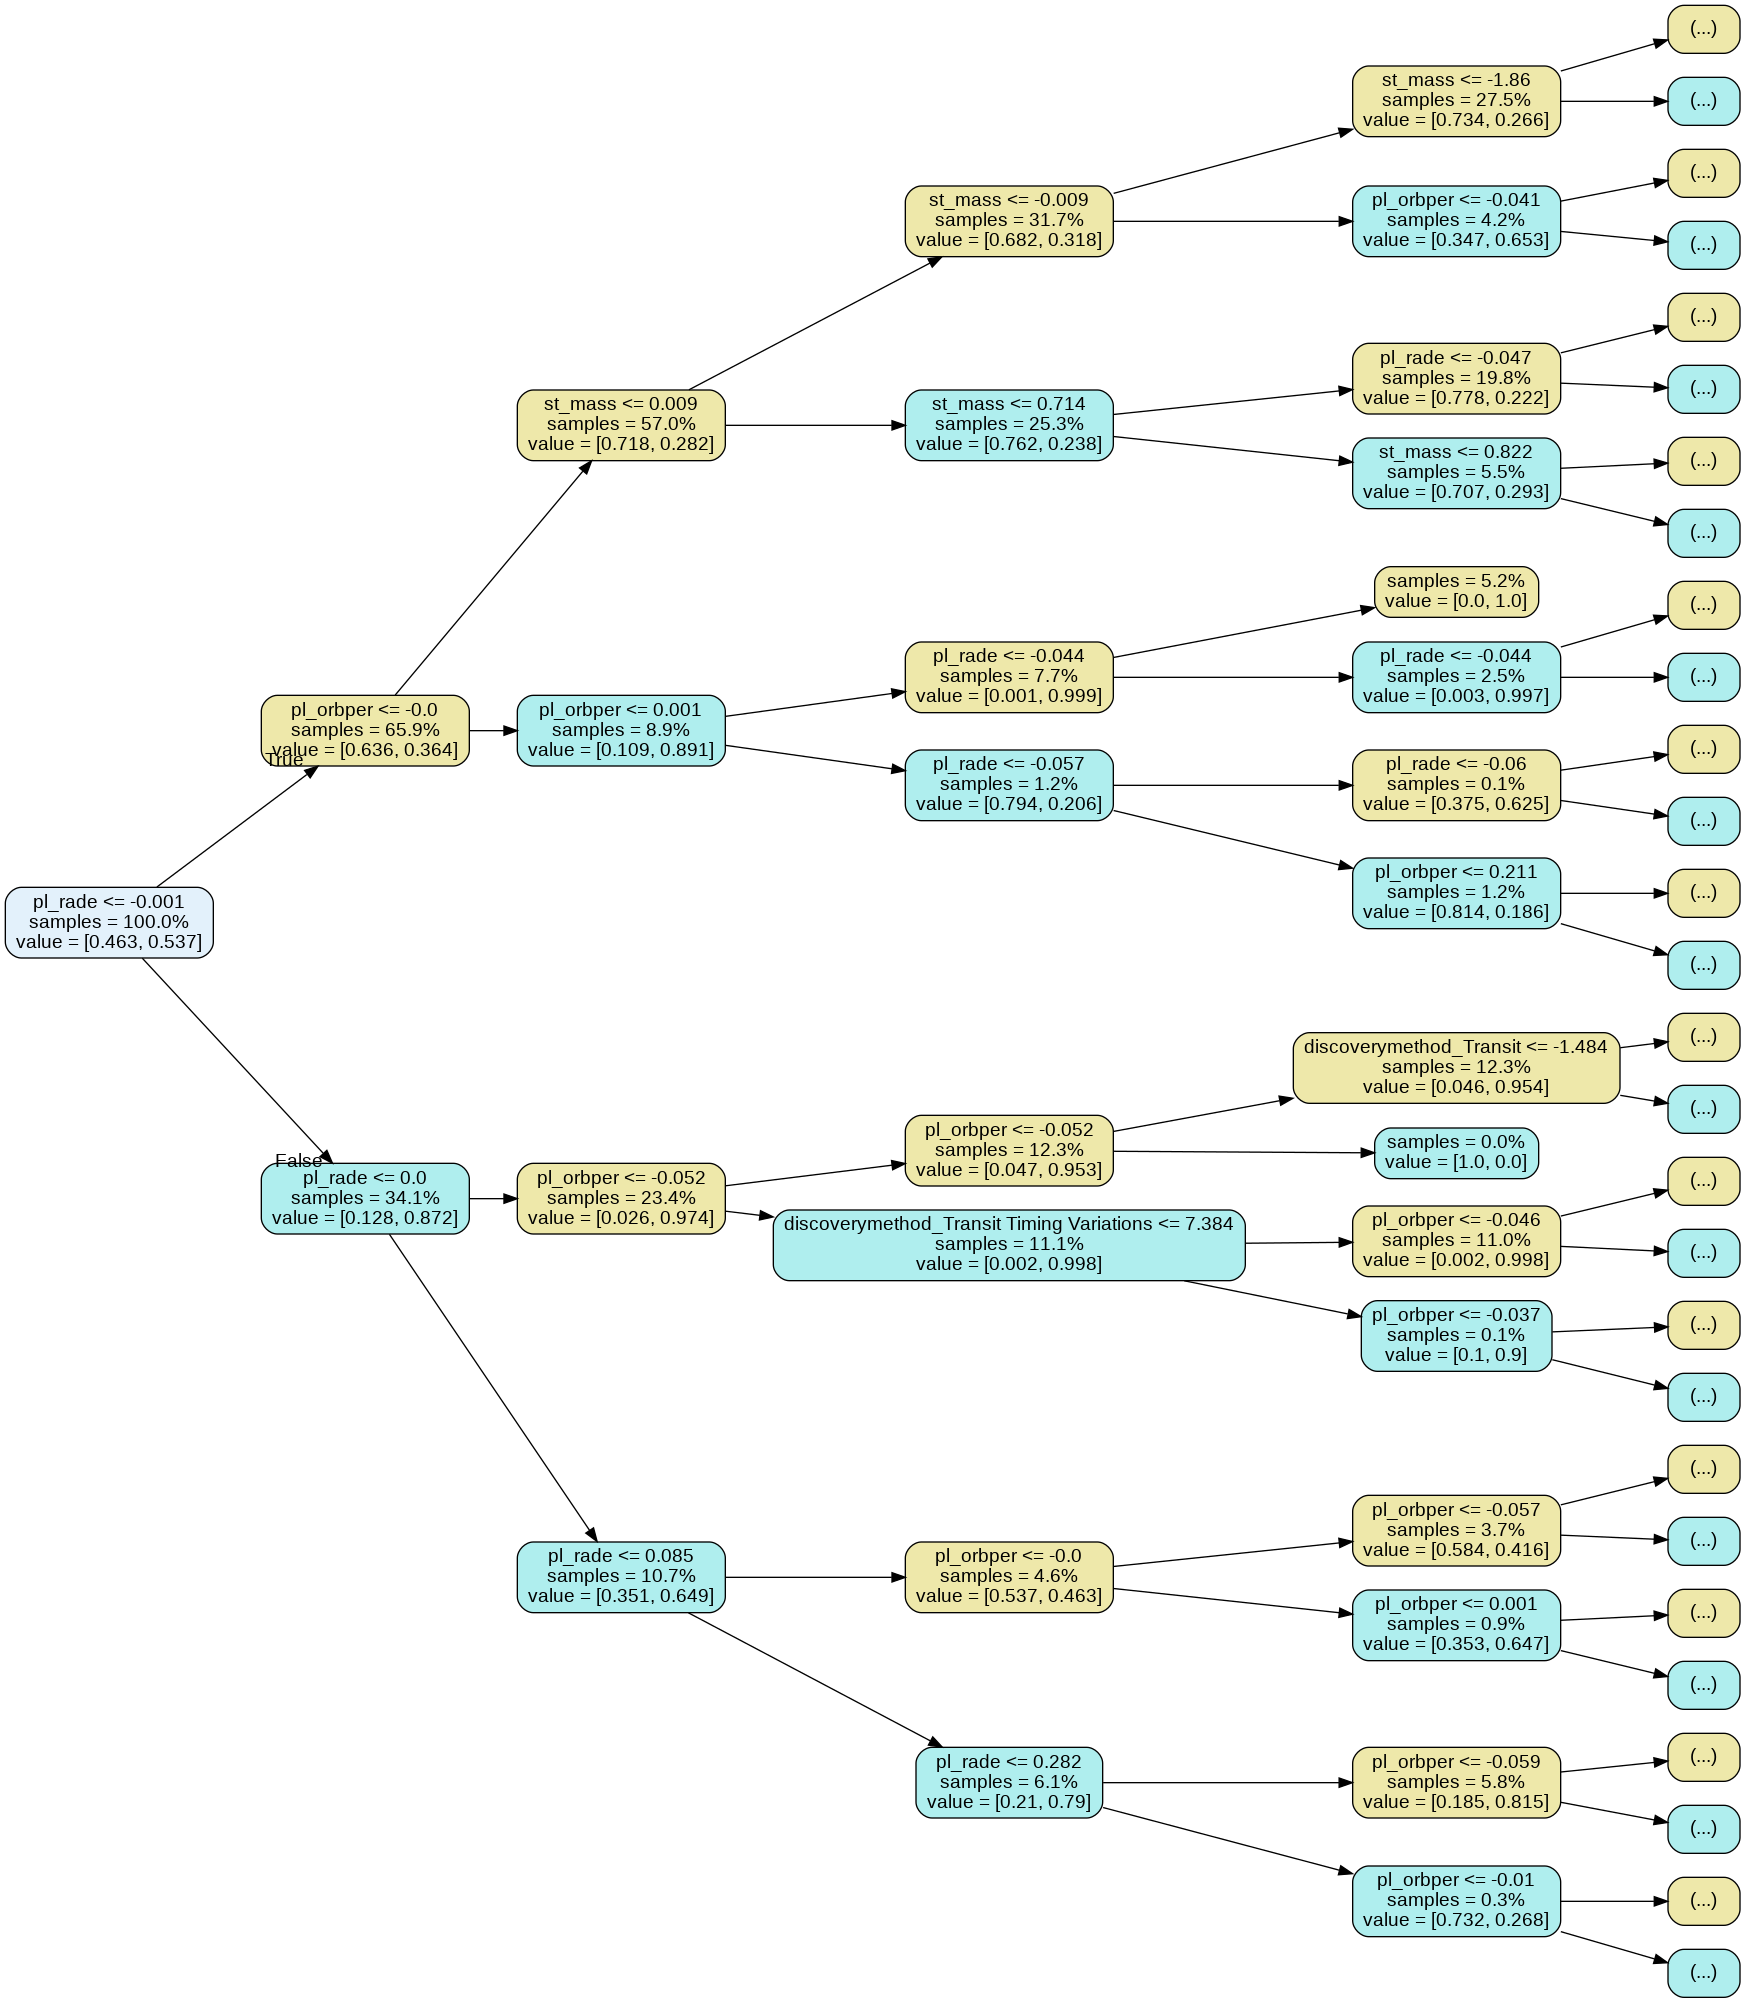

In [ ]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=4, 
                           feature_names=encoded_columns, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True,
                           rotate=True)   
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('palegoldenrod', 'paleturquoise')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

# graph.write_pdf('customcolordtree.pdf')
Image(graph.create_png())

### Cool library for decision trees

In [ ]:
from dtreeviz.trees import *

In [ ]:
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
plt.rcParams['axes.facecolor'] = '#f2fffd'

### Accuracy dips ever so slightly because max_depth is lowered to 3 for better visual

DT train accuracy: 0.7963412988
DT validation accuracy: 0.7969319563
Test Accuracy: 0.7857432158768732


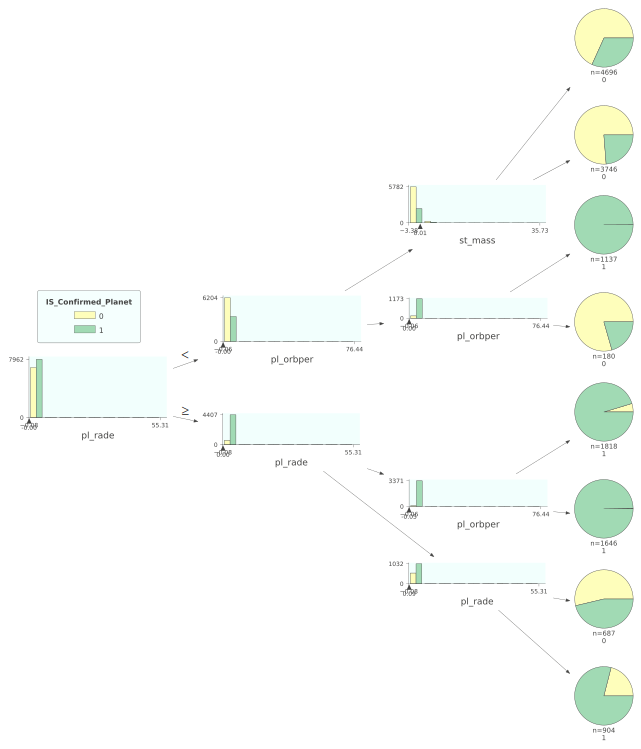

In [ ]:
clas = tree.DecisionTreeClassifier(max_depth=3)  
X_train = X_train_scaled
y_train = y_train
clas.fit(X_train, y_train)

print("DT train accuracy: %0.10f" % clas.score(X_train_scaled, y_train))
print("DT validation accuracy: %0.10f" % clas.score(X_val_scaled, y_val))
y_pred = clas.predict(X_test_scaled)
print("Test Accuracy:", metrics.accuracy_score(y_test, y_pred))

viz = dtreeviz(clas, 
               X_train,
               y_train,
               target_name='IS_Confirmed_Planet',
               feature_names=encoded_columns, 
               class_names=[chr(c) for c in range(ord('0'),ord('9')+1)],
               histtype='bar', 
               orientation ='LR')
viz

### First have to save a svg file then convert to pdf

https://pypi.org/project/svglib/

In [ ]:
viz.save("final.svg")

In [ ]:
pip install svglib

     |████████████████████████████████| 901kB 3.4MB/s 
     |████████████████████████████████| 2.6MB 12.9MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for svglib: filename=svglib-1.0.0-cp36-none-any.whl size=26843 sha256=b09c9b3b52f5ba821b8982fa8e6cf7c659da8a3fd0db6abfa86351b70774dc7c
  Stored in directory: /root/.cache/pip/wheels/e5/8e/78/7c1c7a612f8a87139b1b087b68c2c941976c2f24e1c0259cbb
Successfully built svglib


In [ ]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

In [ ]:
drawing = svg2rlg("final.svg")
renderPDF.drawToFile(drawing, "final.pdf")

### Next Random forest classifier on same columns see if I can improve

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Make sure I have train, val, test set (cross val below I switch this up so confirming now)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(allPlanets, random_state=42, shuffle="True")
train, test = train_test_split(train, random_state=42)
train.shape, val.shape, test.shape

((14814, 32), (6584, 32), (4938, 32))

### Same features as above

In [ ]:
print(target)
print(features)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

IS_Confirmed_Planet
['pl_orbper', 'st_mass', 'pl_rade', 'discoverymethod']


### Below link was helpful for next model

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [ ]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, newcatfeat),
     ('num', numerical_pipe, newnumfeat)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [ ]:
rftrain = rf.score(X_train, y_train)
rfval = rf.score(X_val, y_val)
y_pred = rf.predict(X_test)
rfaccur = metrics.accuracy_score(y_test, y_pred)
print("Random Forrest Classifier: ")
print("\nFeatures: ")
print(*features, sep = ", ")

print("\nRF Train Accuracy: %0.6f" % rftrain)
print("RF Validation Accuracy: %0.6f" % rfval)
print("RF Test Accuracy: %0.6f" % rfaccur)

Random Forrest Classifier: 

Features: 
pl_orbper, st_mass, pl_rade, discoverymethod

RF Train Accuracy: 0.999460
RF Validation Accuracy: 0.813639
RF Test Accuracy: 0.803362


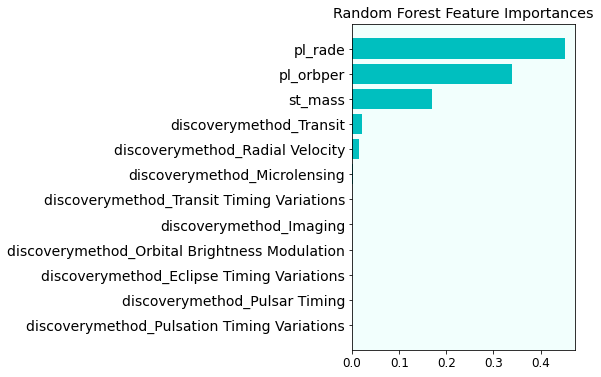

In [ ]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=newcatfeat)
feature_names = np.r_[feature_names, newnumfeat]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(111)
y_ticks = np.arange(0, len(feature_names))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], color='c')
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
plt.show();

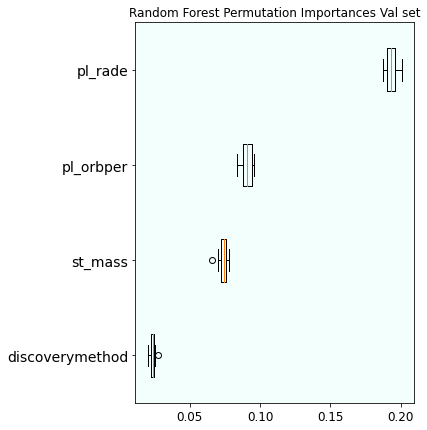

In [ ]:
plt.rcParams.update({'font.size': 12})
result = permutation_importance(rf, X_val, y_val, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(5, 7))
ax = fig.add_subplot(111)

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances Val set", fontdict={'fontsize': 12})
#plt.tight_layout()
#plt.savefig('Rf_imp_feat.png', dpi = 300)
plt.show()

### Adjusting the hyperparameters improves score

In [ ]:
categorical_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe2, newcatfeat),
     ('num', numerical_pipe2, newnumfeat)])

rf_adj = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, 
                                          n_estimators=200, 
                                          max_depth= 15, 
                                          min_samples_split=5,
                                          min_samples_leaf=1))
])
rf_adj.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [ ]:
n_estimators=200 
max_depth=15 
min_samples_split=5
min_samples_leaf=1


rf2train = rf_adj.score(X_train, y_train)
rf2val = rf_adj.score(X_val, y_val)
y_pred = rf_adj.predict(X_test)
rf2accur = metrics.accuracy_score(y_test, y_pred)
print("Random Forest Classifier Adjusted: ")
print("n_estimators ", n_estimators)
print("max_depth ", max_depth)
print("min_samples_split ", min_samples_split)
print("min_samples_leaf ", min_samples_leaf)
print("\nFeatures: ")
print(*features, sep = ", ")
print("\nNew RF Train Accuracy: %0.6f" % rf2train)
print("New RF Validation Accuracy: %0.6f" % rf2val)
print("New RF Test Accuracy: %0.6f" % rf2accur)

Random Forest Classifier Adjusted: 
n_estimators  200
max_depth  15
min_samples_split  5
min_samples_leaf  1

Features: 
pl_orbper, st_mass, pl_rade, discoverymethod

New RF Train Accuracy: 0.858647
New RF Validation Accuracy: 0.819411
New RF Test Accuracy: 0.812070


### Cross Validation

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(allPlanets, random_state=42, shuffle="True")

In [ ]:
train.shape, test.shape

((19752, 32), (6584, 32))

In [ ]:
print(target)
print(features)

IS_Confirmed_Planet
['pl_orbper', 'st_mass', 'pl_rade', 'discoverymethod']


In [ ]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

### Encode discovery method to numeric form

In [ ]:
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Setup the parameters and distributions to sample from
model_params = {"max_depth": [15, None],
              "max_features": randint(1, 15),
              "min_samples_leaf": randint(1, 15),
              "criterion": ["gini", "entropy"]}

### This takes about 5 minutes to run

In [ ]:
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (100 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=20, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train_scaled, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
CV_Train_accur = model.score(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
CV_Test_accur = metrics.accuracy_score(y_test, y_pred)

print("CV Train Accuracy: %0.6f" % CV_Train_accur)
# below prints the same thing as the other model test
# print("Cross validation test accuracy: %0.10f" % model.score(X_test_scaled, y_test))
print("CV Test Accuracy: %0.6f" % CV_Test_accur)

CV Train Accuracy: 0.862647
CV Test Accuracy: 0.823815


In [ ]:
submission = test[['pl_name']].copy()
submission

,pl_name
22104,Kepler-737 b
4749,Kepler-104 b
13672,Kepler-239 b
14180,Kepler-255 c
25448,Proxima Cen b
...,...
8589,Kepler-137 b
1078,HD 113337 b
17367,Kepler-37 d
22464,Kepler-769 b


In [ ]:
submission["My_Guess_of_Confirmed"] = y_pred
actual_confirmed = test['IS_Confirmed_Planet']
submission = submission.join(actual_confirmed)

In [ ]:
submission = submission.reset_index(drop=True)
x = 0
for ind in submission.index:
  if (submission["My_Guess_of_Confirmed"][ind] == submission["IS_Confirmed_Planet"][ind]):
    x += 1
  else:
    continue

In [ ]:
print(x)
print(len(submission))
cv_avg = (x / (len(submission)))
print("This was the average times the model was right: %0.6f" % cv_avg)
print("This was the test accuracy from above: %0.6f" % CV_Test_accur)
if (cv_avg == CV_Test_accur):
  print("matches!")
else:
  print("doesn't match")

5424
6584
This was the average times the model was right: 0.823815
This was the test accuracy from above: 0.823815
matches!


### Going to try to get confusion matrix

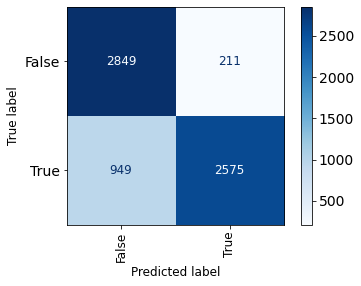

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test_scaled, y_test,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues');

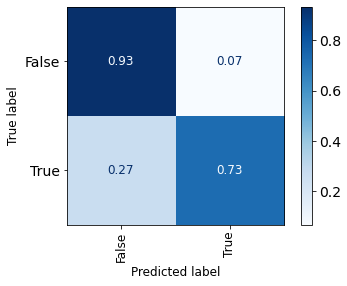

In [ ]:
plot_confusion_matrix(model, X_test_scaled, y_test,
                      normalize='true',
                      values_format='.2f', 
                      xticks_rotation='vertical', cmap='Blues');

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[2849,  211],
       [ 949, 2575]])

#### There were 5,421 correct predictions

In [ ]:
correct_predictions = 2849 + 2575
print(correct_predictions)
print(np.diag(cm).sum())

5424
5424


#### There were 6,584 total predictions made

In [ ]:
total_predictions = len(y_test)
print(total_predictions)
print(cm.sum())

6584
6584


#### Accuracy score will match above

In [ ]:
cmaccuracy = correct_predictions / total_predictions
print(cmaccuracy)

0.8238153098420413


In [ ]:
if (cmaccuracy == CV_Test_accur):
  print("matches!")
else:
  print("doesn't match")

matches!


### Output for project site

In [196]:
print("\nFeatures: ")
print(*features, sep = ", ")

print("\nDecision Tree Classifier: ")
# print("Train accuracy:  %0.6f" % dttrain)
print("Validation accuracy: %0.6f" % dtval)
print("Test Accuracy: %0.6f" % dttest)

print("\nRandom Forrest Classifier: ")
# print("RF Train Accuracy: %0.6f" % rftrain)
print("RF Validation Accuracy: %0.6f" % rfval)
print("RF Test Accuracy: %0.6f" % rfaccur)

print("\nRandom Forest Classifier Adjusted: ")
# print("n_estimators ", n_estimators)
# print("max_depth ", max_depth)
# print("min_samples_split ", min_samples_split)
# print("min_samples_leaf ", min_samples_leaf)
# print("New RF Train Accuracy: %0.6f" % rf2train)
print("New RF Validation Accuracy: %0.6f" % rf2val)
print("New RF Test Accuracy: %0.6f" % rf2accur)

print("\nCross Validation: ")
print("CV Train Accuracy: %0.6f" % CV_Train_accur)
print("CV Test Accuracy: %0.6f" % CV_Test_accur)


Features: 
pl_orbper, st_mass, pl_rade, discoverymethod

Decision Tree Classifier: 
Validation accuracy: 0.794806
Test Accuracy: 0.791211

Random Forrest Classifier: 
RF Validation Accuracy: 0.813639
RF Test Accuracy: 0.803362

Random Forest Classifier Adjusted: 
New RF Validation Accuracy: 0.819411
New RF Test Accuracy: 0.812070

Cross Validation: 
CV Train Accuracy: 0.862647
CV Test Accuracy: 0.823815



Cross Validation: 
CV Train Accuracy: 0.862647
CV Test Accuracy: 0.823815


Do Confusion Matrix Predictions Match?: Yes




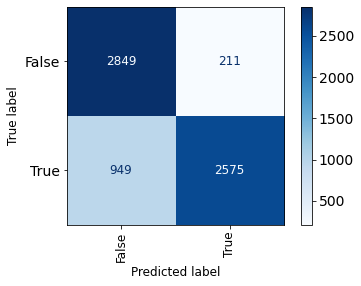

In [199]:
print("\nCross Validation: ")
print("CV Train Accuracy: %0.6f" % CV_Train_accur)
print("CV Test Accuracy: %0.6f" % CV_Test_accur)
print("\n")
if (cmaccuracy == CV_Test_accur):
  print("Do Confusion Matrix Predictions Match?: Yes")
else:
  print("doesn't match")
print("\n")

plot_confusion_matrix(model, X_test_scaled, y_test,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues');

Do CV Confusion Matrix Predictions Match?: Yes


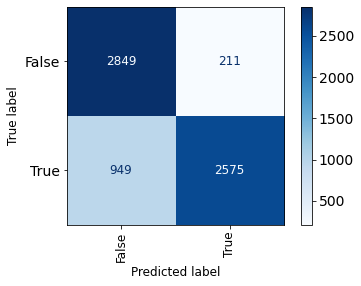

In [202]:
if (cmaccuracy == CV_Test_accur):
  print("Do CV Confusion Matrix Predictions Match?: Yes")
else:
  print("doesn't match")

plot_confusion_matrix(model, X_test_scaled, y_test,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues');